# Torch-dreams

This library was heavily inspired from: [Feature Visualization: How neural networks build up their understanding of images](https://distill.pub/2017/feature-visualization/)

<img src = "https://github.com/Mayukhdeb/torch-dreams/blob/master/images/banner_segmentation_model.png?raw=true">


In [ ]:
!pip install torch-dreams  --upgrade
# !pip install git+https://github.com/Mayukhdeb/torch-dreams  ## for testing only 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from torch_dreams import Dreamer
import torchvision.models as models
plt.rcParams['figure.figsize'] = 5,5

## Minimal example

In [ ]:
model = models.inception_v3(pretrained=True)
dreamy_boi = Dreamer(model, device = 'cuda', quiet =  False)

100%|██████████| 120/120 [00:09<00:00, 12.07it/s]


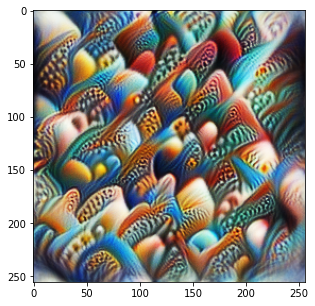

In [5]:
image_param = dreamy_boi.render(
    layers = [model.Mixed_5b],
)
plt.imshow(image_param)
plt.show()

## Not so minimal looking example, but does the same thing as above



In [6]:
image_param = dreamy_boi.render(
    layers = [model.Mixed_5b],
    width = 512,
    height = 256,
    iters = 150,
    lr = 9e-3,
    rotate_degrees = 15,
    scale_max = 1.2,
    scale_min =  0.5,
    translate_x = 0.2,
    translate_y = 0.2,
    custom_func = None,
    weight_decay = 1e-2,
    grad_clip = 1,
)

100%|██████████| 150/150 [00:06<00:00, 23.80it/s]


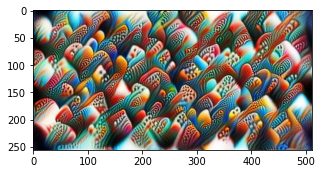

In [7]:
plt.imshow(image_param)
plt.show()

## Visualizing individual channels


We basically optimize the input image to maximize activations of a certain channel of a layer in the neural network.

The next step now would be to define a `custom_func` that would enable use to selectively optimize a single channel. We could've made a simpler function, but this would be useful when we'll be running the optimizations on a lot of channels

In [8]:
"""
feel free to use more layers for experiments 
"""
layers_to_use = [model.Mixed_6b.branch1x1.conv]

def make_custom_func(layer_number = 0, channel_number= 0): 
    def custom_func(layer_outputs):
        loss = layer_outputs[layer_number][channel_number].mean()
        return -loss
    return custom_func

Now in order to optimize the **7th channel** of the **first layer** mentioned in `layers_to_use` we define the custom loss as:



In [9]:
my_custom_func = make_custom_func(layer_number= 0, channel_number = 119)

100%|██████████| 200/200 [00:06<00:00, 28.78it/s]


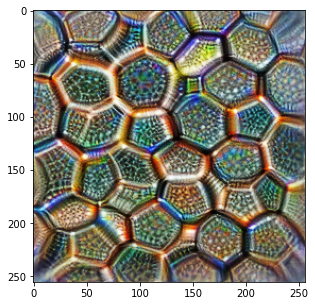

In [10]:
image_param = dreamy_boi.render(
    layers = layers_to_use,
    custom_func = my_custom_func,
    iters = 200
)
plt.imshow(image_param)
plt.show()

## Running on custom images

In [ ]:
!wget -O animals.jpg "https://eli5.readthedocs.io/en/latest/_images/keras-image-classifiers_5_11.png"

In [13]:
from torch_dreams.custom_image_param import CustomImageParam

In [14]:
my_custom_func = make_custom_func(layer_number = 0, channel_number = 19)
layers_to_use = [model.Mixed_6b.branch1x1.conv]

In [16]:
param = CustomImageParam(image = 'animals.jpg', device= 'cuda')

image_param = dreamy_boi.render(
    image_parameter= param,
    layers = layers_to_use,
    lr = 2e-4,
    # weight_decay= 1e-1,
    iters = 20,  ## mild
    custom_func = my_custom_func
)

100%|██████████| 20/20 [00:02<00:00,  7.16it/s]


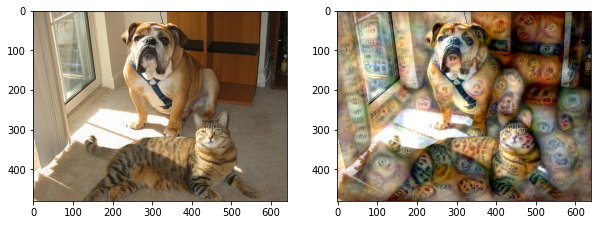

In [17]:
import cv2
fig, ax = plt.subplots(nrows= 1, ncols= 2, figsize=(10,5))
ax.flat[0].imshow(cv2.cvtColor(cv2.imread('animals.jpg'), cv2.COLOR_BGR2RGB))
ax.flat[1].imshow(image_param)

## Caricatures with googlenet

They help us by creating a new image that has a similar but more extreme activation pattern to the input image at a given layer (or multiple layers at a time)



Inspired from: https://github.com/tensorflow/lucid/issues/121

In [19]:
from torch_dreams.custom_image_param import CustomImageParam

param = CustomImageParam('animals.jpg', device = 'cuda')
image_tensor = param.to_nchw_tensor()  ## could be any other NCHW tensor

In [ ]:
model = models.googlenet(pretrained = True)
dreamy_boi = Dreamer(model = model, quiet= False, device= 'cuda')

image_param = dreamy_boi.caricature(
    input_tensor = image_tensor, 
    layers = [model.inception4c],   ## feel free to append more layers for more interesting caricatures 
    power= 1.2,
)

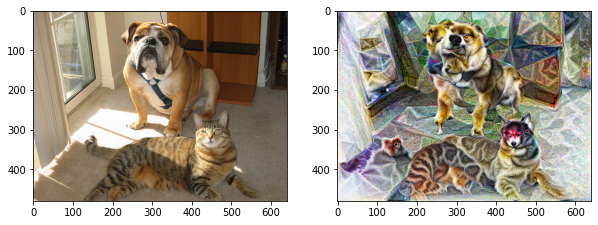

In [21]:
fig, ax = plt.subplots(nrows= 1, ncols= 2, figsize=(10,10))
ax.flat[0].imshow(param)
ax.flat[1].imshow(image_param)

## Using multiple models 

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

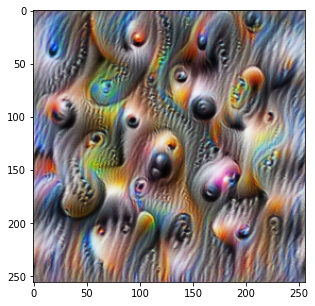

In [22]:
import matplotlib.pyplot as plt
import torchvision.models as models

from torch_dreams import Dreamer
from torch_dreams.model_bunch import ModelBunch

bunch = ModelBunch(
    model_dict = {
        'inception': models.inception_v3(pretrained=True).eval(),
        'resnet':    models.resnet18(pretrained= True).eval()
    }
)

layers_to_use = [
            bunch.model_dict['inception'].Mixed_6a,
            bunch.model_dict['resnet'].layer2[0].conv1
        ]

dreamy_boi = Dreamer(model = bunch, quiet= True, device= 'cuda')

def custom_func(layer_outputs):
    loss =   layer_outputs[0].mean()*2.0 + layer_outputs[1][89].mean() 
    return -loss

image_param = dreamy_boi.render(
    layers = layers_to_use,
    custom_func= custom_func,
    iters= 100
)

plt.rcParams['figure.figsize'] = 5,5
plt.imshow(image_param)
plt.show()

## Experiments with a segmentation model

In [ ]:
segmentation_model = models.segmentation.deeplabv3_resnet50(pretrained=True).eval()
dreamy_boi = Dreamer(segmentation_model, quiet = False, device = 'cuda')
layers_to_use = [
    segmentation_model.aux_classifier[-1]
]

classes = ['__background__', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

### Caricatures on a segmentation model

In [ ]:
!wget -O horse.jpg "http://bhsireland.com/wp-content/uploads/2019/03/white-horse-300x293.jpg"

In [25]:
list(dict(segmentation_model.backbone.named_children()).keys())

['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3', 'layer4']

In [26]:

param = CustomImageParam('horse.jpg', device = 'cuda')
image_tensor = param.to_nchw_tensor()  ## could be any other NCHW tensor

image_param = dreamy_boi.caricature(
    input_tensor = image_tensor, 
    layers = [segmentation_model.backbone.layer2],         ## feel free to append more layers for more interesting caricatures 
    power= 1.2,                     ## higher -> more "exaggerated" features
)

100%|██████████| 120/120 [00:10<00:00, 11.23it/s]


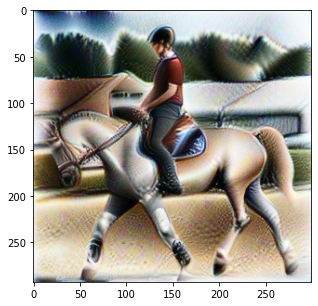

In [27]:
plt.imshow(image_param)
plt.show()

### Optimizing output channels 

In [28]:
from tqdm import tqdm

In [ ]:
all_outs = []
for i in tqdm(range(21)):
    my_func = make_custom_func(layer_number=0, channel_number= i)
    image_param = dreamy_boi.render(
        width = 256,
        height = 256,
        iters = 190,
        layers = layers_to_use,
        custom_func= my_func,
        lr = 8e-3,
        rotate_degrees = 25,
        scale_max= 1.2,
        scale_min= 0.2
    )
    all_outs.append(image_param)

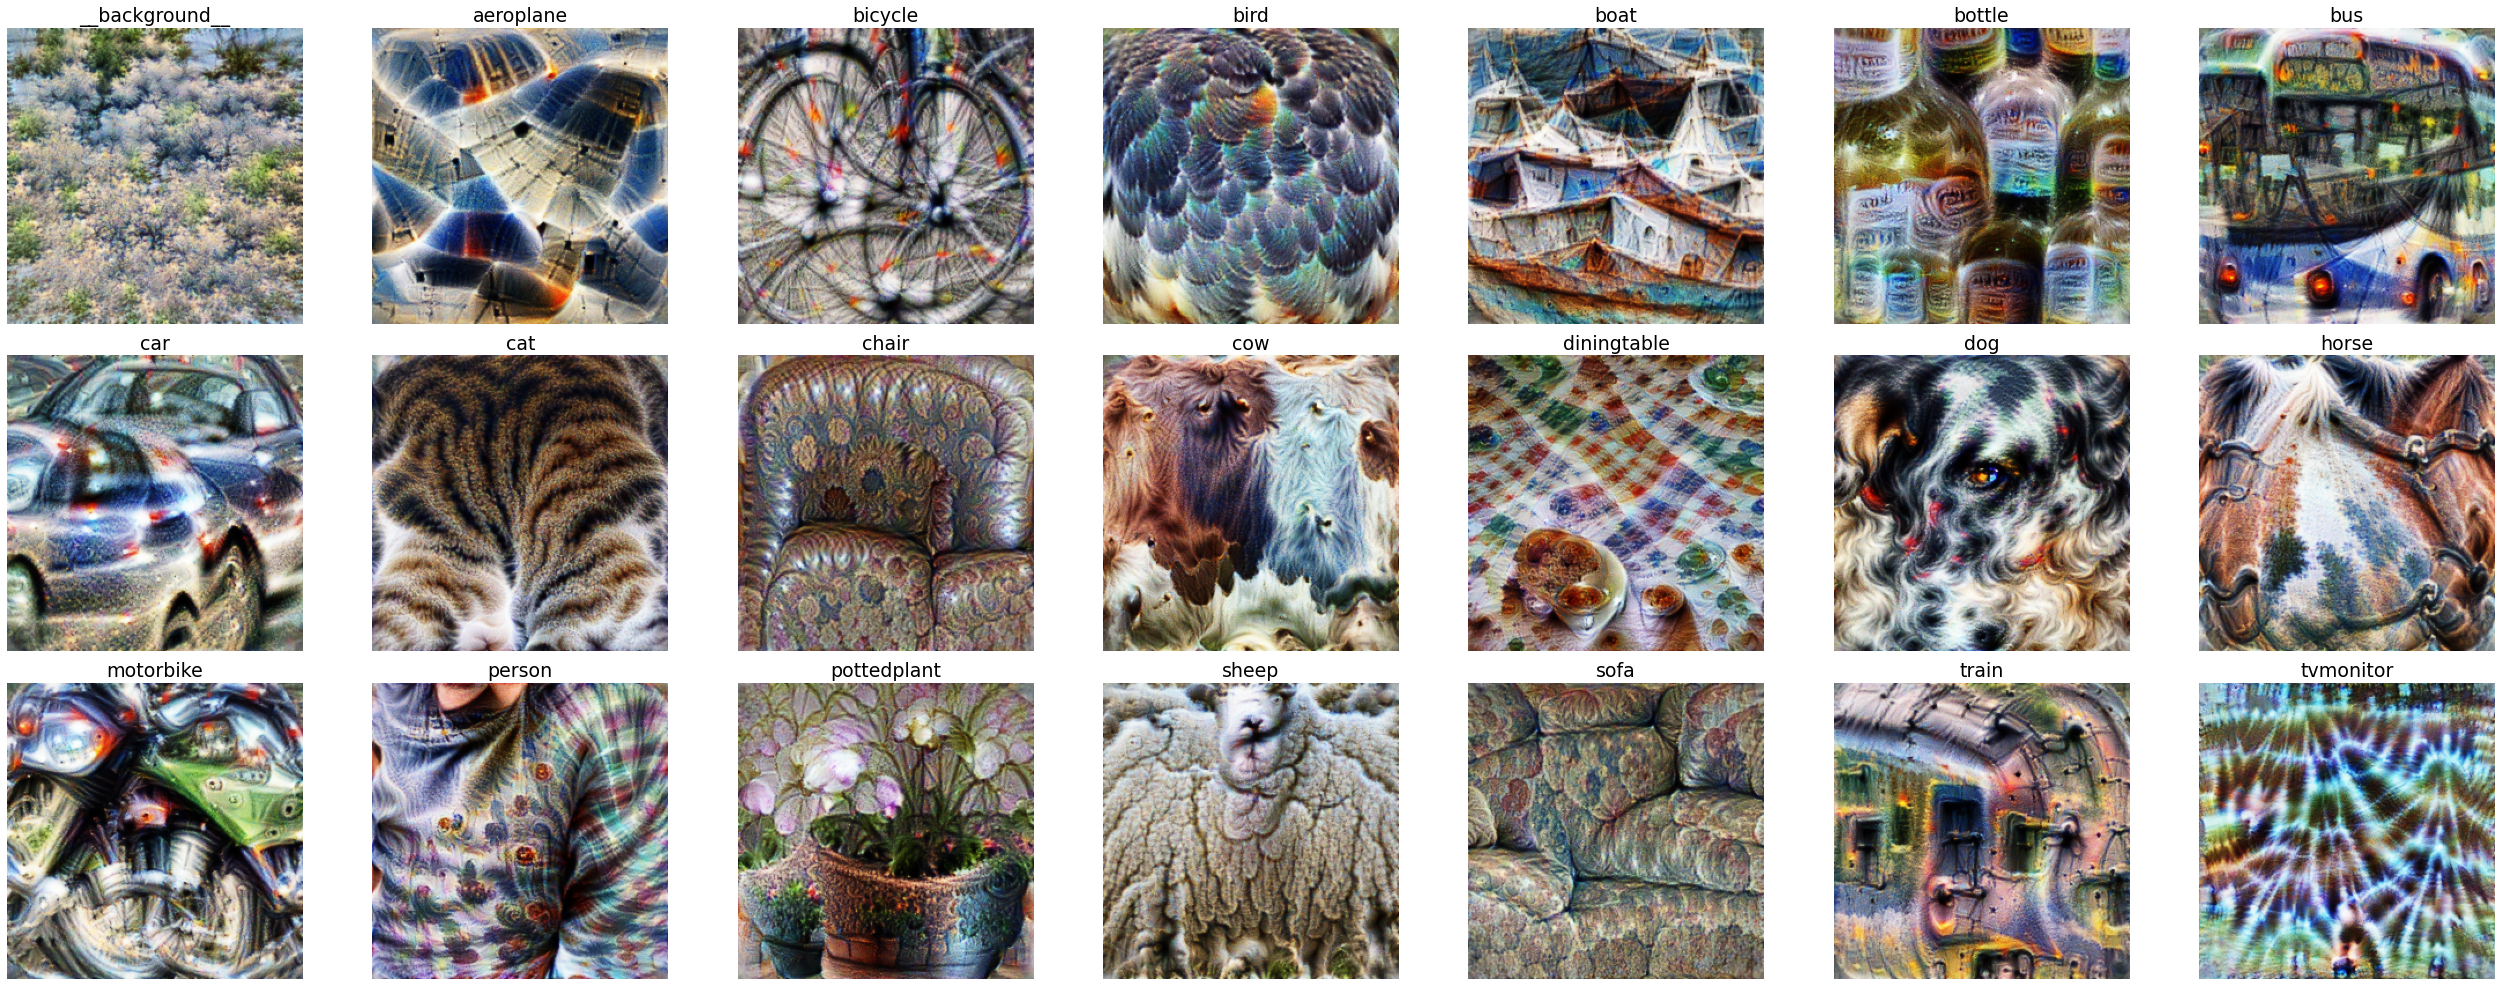

In [30]:
fig, ax = plt.subplots(nrows= 3, ncols= len(classes)//3, figsize=(18*2, 6*2.3))

for i in range(len(all_outs)):
    ax.flat[i].imshow(all_outs[i])
    ax.flat[i].set_title(classes[i], fontsize = 19)
    ax.flat[i].axis("off")
fig.tight_layout()

In [31]:
cherry_picked_indices = [6,15, 16, 14, 4, 13]
all_outs_cherry = []
dreamy_boi.quiet = True

for i in cherry_picked_indices:
    my_func = make_custom_func(layer_number=0, channel_number= i)
    image_param = dreamy_boi.render(
        width = 512,
        height = 256,
        iters = 250,
        layers = layers_to_use,
        custom_func= my_func,
        lr = 8e-3,
        rotate_degrees = 15,
        scale_max= 1.2,
        scale_min= 0.1,
        weight_decay = 1e-3
    )
    all_outs_cherry.append(image_param)

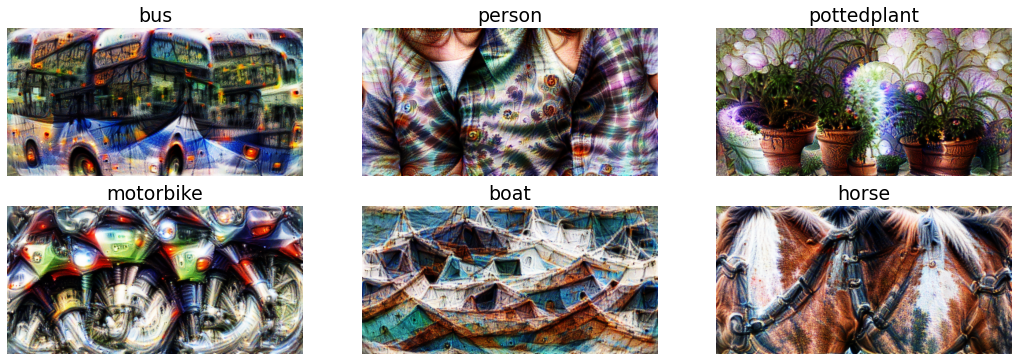

In [32]:
fig, ax = plt.subplots(nrows= 2, ncols= 3, figsize=(18, 6))

c = 0
for i in cherry_picked_indices:
    ax.flat[c].imshow(all_outs_cherry[c])
    ax.flat[c].set_title(classes[i], fontsize = 19)
    ax.flat[c].axis("off")
    c +=1 

In [33]:
!mkdir images
c = 0
for i in cherry_picked_indices:
    filename = 'images/' + classes[i]+ '.jpg'
    all_outs_cherry[c].save(filename)
    print(filename)

images/bus.jpg
images/person.jpg
images/pottedplant.jpg
images/motorbike.jpg
images/boat.jpg
images/horse.jpg


## Let's combine features of a segmentation model and inception_v3 




In [34]:
from torch_dreams.model_bunch import ModelBunch

In [36]:
bunch = ModelBunch(
    model_dict = {
        'deeplab': models.segmentation.deeplabv3_resnet50(pretrained=True).eval(),
        'inception':  models.inception_v3(pretrained= True).eval(),
    }
)

layers_to_use = [
            bunch.model_dict['deeplab'].aux_classifier[-1],
            bunch.model_dict['inception'].Mixed_5b,
        ]

dreamy_boi = Dreamer(model = bunch, quiet= False, device= 'cuda')


In [37]:
def custom_func(layer_outputs):
    loss =  layer_outputs[1].mean()*10  + layer_outputs[0][16].mean() *0.2
    return -loss


In [38]:
image_param = dreamy_boi.render(
    width = 512,
    height = 256,
    iters = 150,
    layers = layers_to_use,
    custom_func= custom_func,
    lr= 8e-3,
    rotate_degrees = 15,
    scale_max= 1.2,
    scale_min= 0.5,
    weight_decay = 1e-3
)

100%|██████████| 150/150 [00:14<00:00, 10.24it/s]


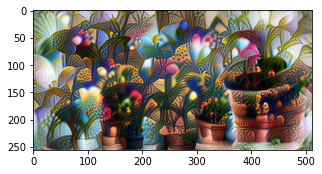

In [39]:
plt.imshow(image_param)
plt.show()

In [40]:
image_param.save('flower_plus_layer_texture.jpg')

## Masked image parameters
---



In [ ]:
!wget -O mountains.jpg "https://cdn.britannica.com/67/19367-050-885866B4/Valley-Taurus-Mountains-Turkey.jpg"

In [42]:
model = models.googlenet(pretrained=True)
dreamy_boi = Dreamer(model, device = 'cuda', quiet =  False)

In [44]:
from torch_dreams.masked_image_param import MaskedImageParam
import torch

mask = torch.ones(1,1,1067,1600)

for i in range(0, 1067, 1):  ## vertical gradient
    mask[:,:,i,:] = (i/1067)**2

param = MaskedImageParam(
    image= 'mountains.jpg',  ## optional
    mask_tensor = mask,
    device = 'cuda'
)

In [45]:
'''
might take some time depending on the resolution
'''
param = dreamy_boi.render(
    layers = [model.inception4c],
    image_parameter= param,
    lr = 1e-4,
    grad_clip= 0.1,
    weight_decay= 1e-1,
    iters= 200,
    scale_min = 0.2,
    scale_max = 1.0
)

param.save('masked_param_output.jpg')

100%|██████████| 200/200 [00:20<00:00,  9.73it/s]


(-0.5, 1599.5, 1066.5, -0.5)

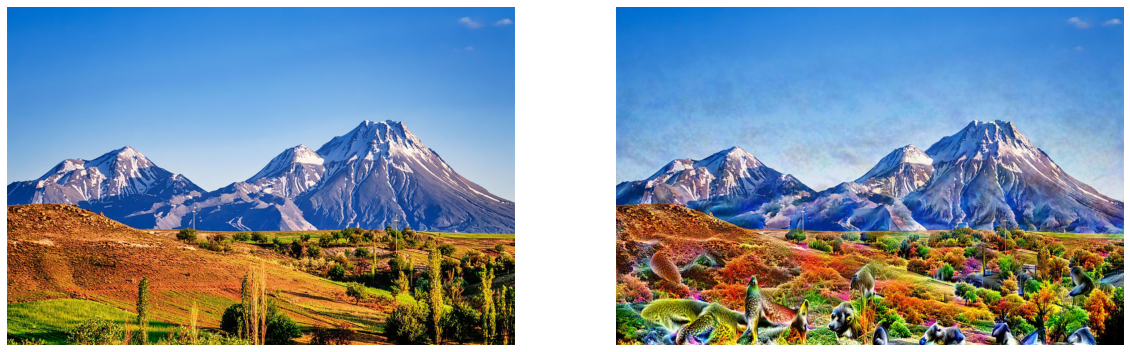

In [46]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (20 , 10))
ax[1].imshow(plt.imread('masked_param_output.jpg'))
ax[0].imshow(plt.imread('mountains.jpg'))

ax[0].axis('off')
ax[1].axis('off')

## Batched generation for large scale experiments

The `BatchedAutoImageParam` paired with the `BatchedObjective` can be used to generate multiple feature visualizations in parallel. This takes up more memory based on the batch size, but is also faster than generating one visualization at a time.

In [47]:
!mkdir results

In [48]:
from torch_dreams import Dreamer
import torchvision.models as models
from torch_dreams.batched_objective import BatchedObjective
from torch_dreams.batched_image_param import BatchedAutoImageParam

model = models.inception_v3(pretrained=True)
dreamy_boi = Dreamer(model, device="cuda")

## specify list of neuron indices to visualize
batch_neuron_indices = [i for i in range(10,20)]

## set up a batch of trainable image parameters
bap = BatchedAutoImageParam(
    batch_size=len(batch_neuron_indices), 
    width=256, 
    height=256, 
    standard_deviation=0.01
)

## objective generator for each neuron
def make_custom_func(layer_number=0, channel_number=0):
    def custom_func(layer_outputs):
        loss = layer_outputs[layer_number][channel_number].norm()
        return -loss

    return custom_func

## prepare objective functions for each neuron index
batched_objective = BatchedObjective(
    objectives=[make_custom_func(channel_number=i) for i in batch_neuron_indices]
)

## render activation maximization signals
result_batch = dreamy_boi.render(
    layers=[model.Mixed_5b],
    image_parameter=bap,
    iters=120,
    custom_func=batched_objective,
)

## save results in a folder
for i in batch_neuron_indices:
    result_batch[batch_neuron_indices.index(i)].save(f"results/{i}.jpg")

100%|██████████| 120/120 [00:10<00:00, 10.97it/s]


## Generating synthetic activation maximization signals for lots of neurons

In [49]:
def chunks(lst, n):
    """Yield successive n-sized chunks from list"""
    for i in range(0, len(lst), n):
        yield lst[i : i + n]

In [50]:
BATCH_SIZE = 40
NEURON_INDICES_TO_VISUALIZE = [i for i in range(128)]

for batch_neuron_indices in chunks(NEURON_INDICES_TO_VISUALIZE, n=BATCH_SIZE):

    bap = BatchedAutoImageParam(
        batch_size=len(batch_neuron_indices), width=256, height=256, standard_deviation=0.01
    )

    def make_custom_func(layer_number=0, channel_number=0):
        def custom_func(layer_outputs):
            loss = layer_outputs[layer_number][channel_number].norm()
            return -loss

        return custom_func

    batched_objective = BatchedObjective(
        objectives=[make_custom_func(channel_number=i) for i in batch_neuron_indices]
    )

    result_batch = dreamy_boi.render(
        layers=[model.Mixed_5b],
        image_parameter=bap,
        iters=120,
        custom_func=batched_objective,
    )

    for i in batch_neuron_indices:
        result_batch[batch_neuron_indices.index(i)].save(f"results/{i}.jpg")

100%|██████████| 120/120 [00:09<00:00, 13.06it/s]
